# Model

In [1]:
#Librarys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import f1_score
import warnings

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor


warnings.filterwarnings("ignore", category=DeprecationWarning) 

import sys
sys.path.append('../')
from helper.lazy_regression import TooLazyForRegression
from helper.feature_extract import extract_highest_amplitude_features_with_mp

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Import data
df_mpa = pd.read_table('../data/data_mpa.txt', sep=' ')
df_mpa = extract_highest_amplitude_features_with_mp(df=df_mpa, sensor_types=[['M01', 'M02', 'M03', 'M04']], create_one_sensor_feature=True, n_processes=4, keep_columns=False)
df_mpa = df_mpa[df_mpa['start_time'].str.contains('2021')]
df_mpa = df_mpa.drop(["start_time","packnr","velocity"], axis=1)
df_spg = pd.read_table('../data/data_spg.txt', sep=' ')
df_spg = extract_highest_amplitude_features_with_mp(df=df_spg, sensor_types=[['G01', 'G02']], create_one_sensor_feature=True, n_processes=4, keep_columns=False)
df_spg = df_spg[df_spg['start_time'].str.contains('2021')]
df_spg = df_spg.drop(["start_time","packnr","velocity"], axis=1)
df_sps = pd.read_table('../data/data_sps.txt', sep=' ')
df_sps = extract_highest_amplitude_features_with_mp(df=df_sps, sensor_types=[['G01', 'G02'], ['M01'], ['S01']], create_one_sensor_feature=True, n_processes=4, keep_columns=False)
df_sps = df_sps[df_sps['start_time'].str.contains('2021')]
df_sps = df_sps.drop(["start_time","packnr","velocity"], axis=1)

INFO || Extracting Max Features for types: ['M01', 'M02', 'M03', 'M04']
INFO || Extracting Max Features for types: ['G01', 'G02']
INFO || Extracting Max Features for types: ['G01', 'G02']
INFO || Extracting Max Features for types: ['M01']
INFO || Extracting Max Features for types: ['S01']


In [83]:
def transformer(df,X_log=False,y_log=False,cols = None):
    data = df.copy()
    if  X_log == False and y_log== True:
        data["size_mm"] = np.log1p(data["size_mm"])
        return data
    elif X_log == True and y_log== False:
        data= np.log1p(data)
        data[cols] = np.exp(data[cols])-1
        data["size_mm"] = np.exp(data["size_mm"])-1
        return data
    elif X_log == True and y_log== True:
        data= np.log1p(data)
        data[cols] = np.exp(data[cols])-1
        return data
    else:
        data = data
        return data

#### Zielvariable log

In [38]:
df_mpa_log_y = transformer(df_mpa,X_log=False,y_log=True)
df_spg_log_y = transformer(df_spg,X_log=False,y_log=True)
df_sps_log_y = transformer(df_sps,X_log=False,y_log=True)

#### X log

In [84]:
mpa_cols = (df_mpa.loc[:, df_mpa.columns.str.contains('freq')]).columns
spg_cols = (df_spg.loc[:, df_spg.columns.str.contains('freq')]).columns
sps_cols = (df_sps.loc[:, df_sps.columns.str.contains('freq')]).columns

In [87]:
df_mpa_log_X = transformer(df_mpa,X_log=True,y_log=False,cols=mpa_cols)
df_spg_log_X = transformer(df_spg,X_log=True,y_log=False,cols=spg_cols)
df_sps_log_X = transformer(df_sps,X_log=True,y_log=False,cols=sps_cols)

#### Intelligent log

In [88]:
mpa_cols = (df_mpa.loc[:, df_mpa.columns.str.contains('freq')]).columns
spg_cols = (df_spg.loc[:, df_spg.columns.str.contains('freq')]).columns
sps_cols = (df_sps.loc[:, df_sps.columns.str.contains('freq')]).columns

In [29]:
df_mpa_int_log = transformer(df_mpa,X_log=True,y_log=True,cols=mpa_cols)
df_spg_int_log = transformer(df_spg,X_log=True,y_log=True,cols=spg_cols)
df_sps_int_log = transformer(df_sps,X_log=True,y_log=True,cols=sps_cols)

## 1. MPA ohne log

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [00:32<00:00,  2.16s/it]


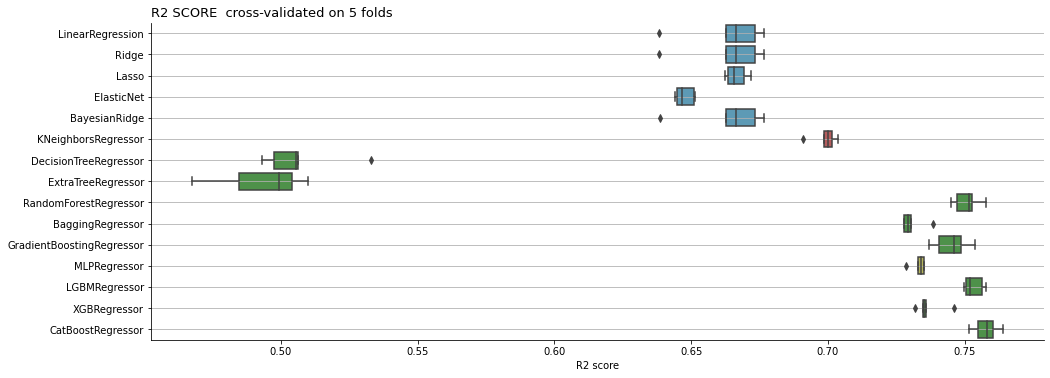

Mean of all linear-Models: 0.661
Mean of all tree-Models: 0.684
Mean of all neighbor-Models: 0.699
Mean of all neuronal-Models: 0.733


In [48]:
data = df_mpa
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_mpa_mean_r2 = lazy.mean_r2()

### 1.1 MPA log Zielvariable

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [00:27<00:00,  1.80s/it]


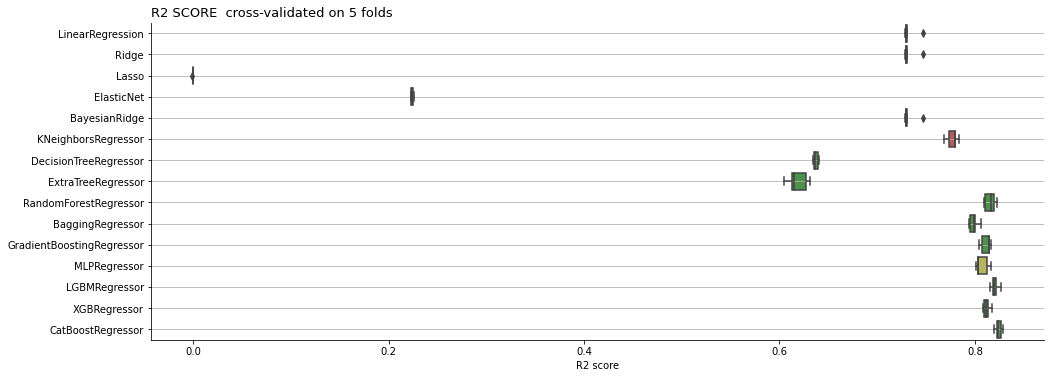

Mean of all linear-Models: 0.484
Mean of all tree-Models: 0.767
Mean of all neighbor-Models: 0.777
Mean of all neuronal-Models: 0.807


In [49]:
data = df_mpa_log_y
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_mpa_log_y_mean_r2 = lazy.mean_r2()

### 1.2 MPA log Int

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [00:30<00:00,  2.02s/it]


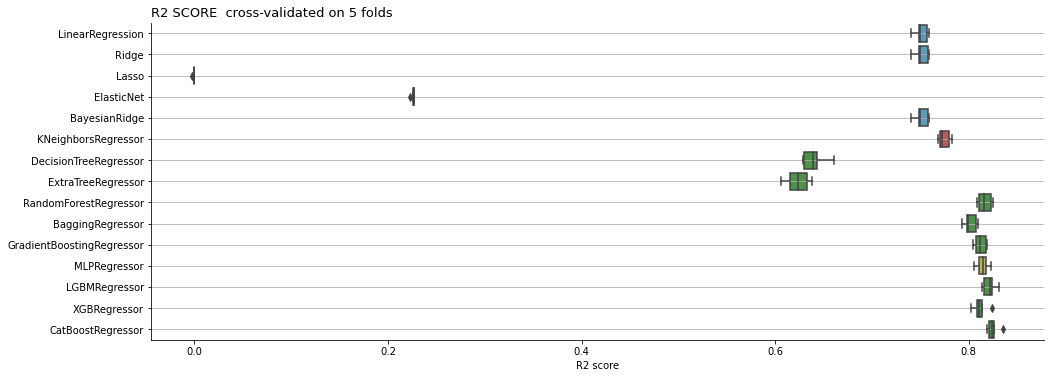

Mean of all linear-Models: 0.496
Mean of all tree-Models: 0.769
Mean of all neighbor-Models: 0.775
Mean of all neuronal-Models: 0.814


In [51]:
data = df_mpa_int_log
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_mpa_log_int_mean_r2 = lazy.mean_r2()

### 1.3 MPA log X

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [00:32<00:00,  2.19s/it]


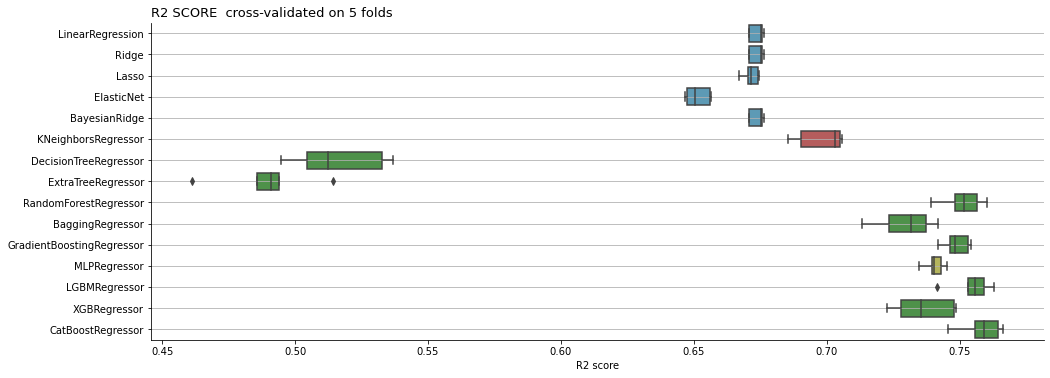

Mean of all linear-Models: 0.669
Mean of all tree-Models: 0.686
Mean of all neighbor-Models: 0.698
Mean of all neuronal-Models: 0.741


In [90]:
data = df_mpa_log_X
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_mpa_log_X_mean_r2 = lazy.mean_r2()

## 2. SPG

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.08s/it]


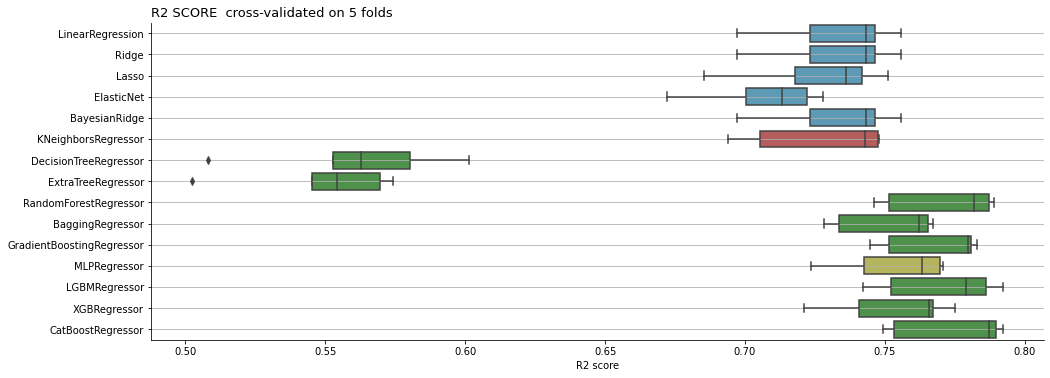

Mean of all linear-Models: 0.727
Mean of all tree-Models: 0.712
Mean of all neighbor-Models: 0.727
Mean of all neuronal-Models: 0.754


In [53]:
data = df_spg
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_spg_mean_r2 = lazy.mean_r2()

### 2.1 SPG log Zielvariable

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [00:14<00:00,  1.06it/s]


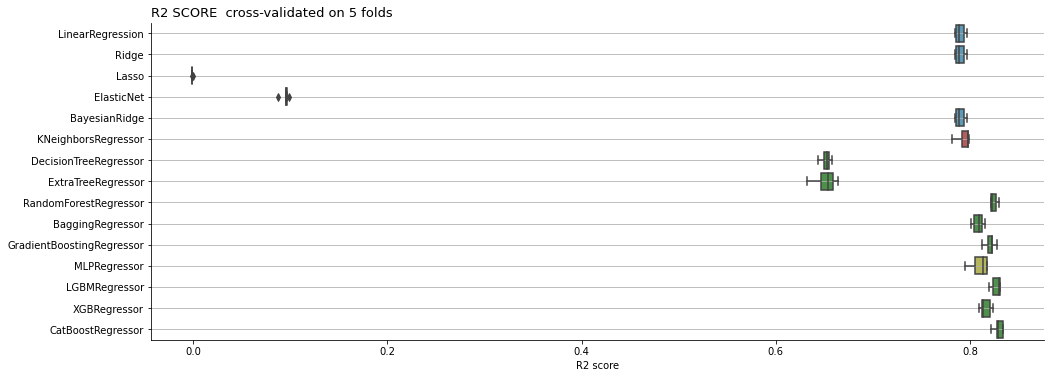

Mean of all linear-Models: 0.493
Mean of all tree-Models: 0.779
Mean of all neighbor-Models: 0.794
Mean of all neuronal-Models: 0.81


In [54]:
data = df_spg_log_y
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_spg_log_y_mean_r2 = lazy.mean_r2()

### 2.2 SPG log Int

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [00:14<00:00,  1.03it/s]


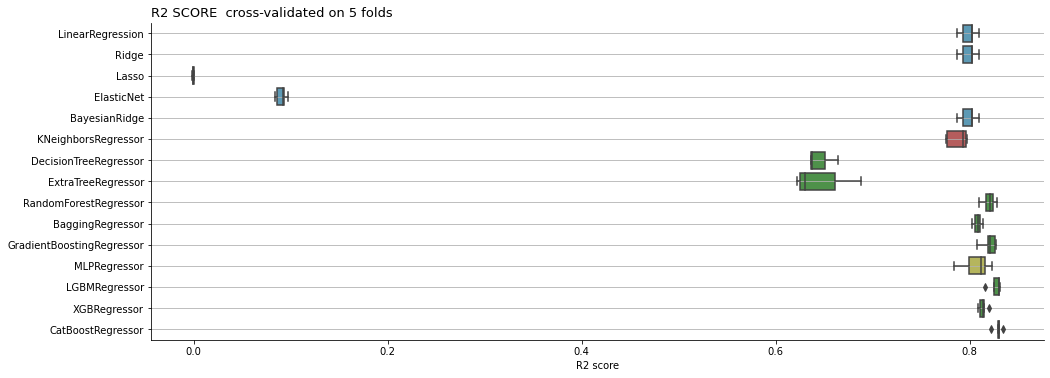

Mean of all linear-Models: 0.497
Mean of all tree-Models: 0.776
Mean of all neighbor-Models: 0.788
Mean of all neuronal-Models: 0.807


In [55]:
data = df_spg_int_log
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_spg_log_int_mean_r2 = lazy.mean_r2()

### 2.3 SPG log X

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.08s/it]


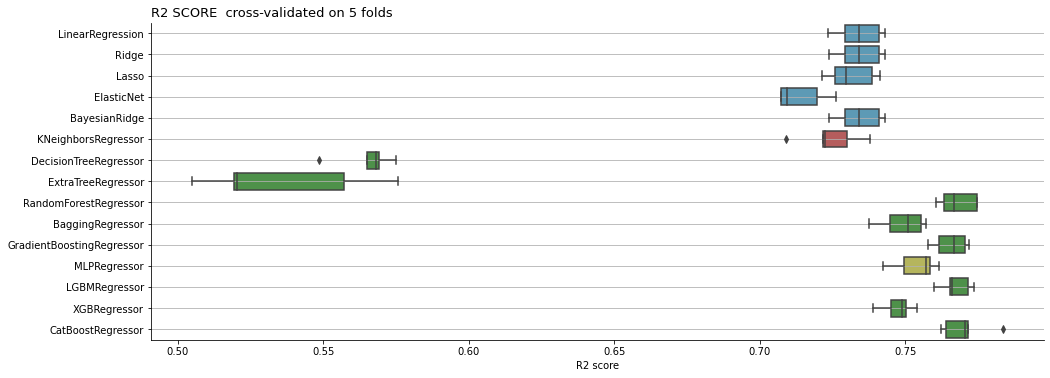

Mean of all linear-Models: 0.73
Mean of all tree-Models: 0.709
Mean of all neighbor-Models: 0.724
Mean of all neuronal-Models: 0.754


In [91]:
data = df_spg_log_X
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_spg_log_X_mean_r2 = lazy.mean_r2()

## 3. SPS

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [00:34<00:00,  2.32s/it]


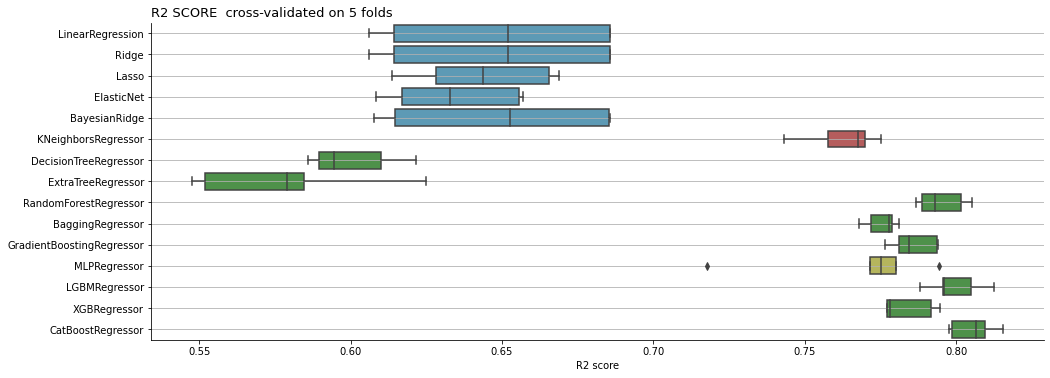

Mean of all linear-Models: 0.645
Mean of all tree-Models: 0.74
Mean of all neighbor-Models: 0.763
Mean of all neuronal-Models: 0.768


In [57]:
data = df_sps
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_sps_mean_r2 = lazy.mean_r2()

### 3.1 SPS log Zielvariable

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [00:30<00:00,  2.04s/it]


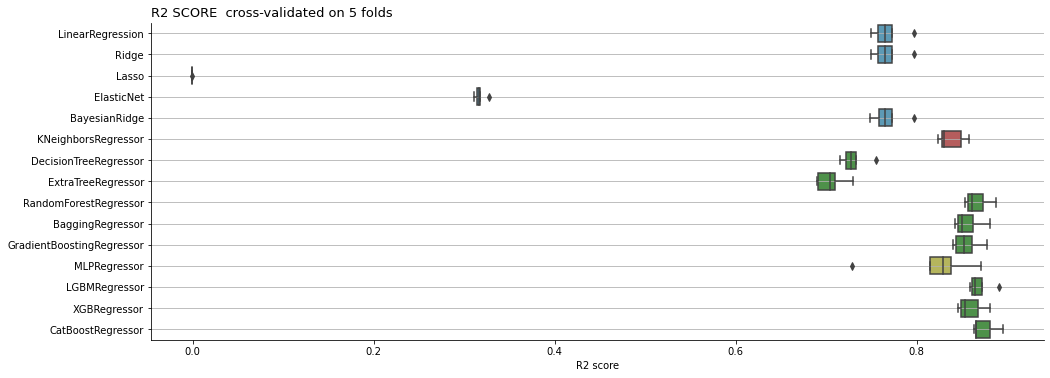

Mean of all linear-Models: 0.524
Mean of all tree-Models: 0.827
Mean of all neighbor-Models: 0.838
Mean of all neuronal-Models: 0.816


In [58]:
data = df_sps_log_y
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_sps_log_y_mean_r2 = lazy.mean_r2()

### 3.2 SPS log Int

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [00:32<00:00,  2.18s/it]


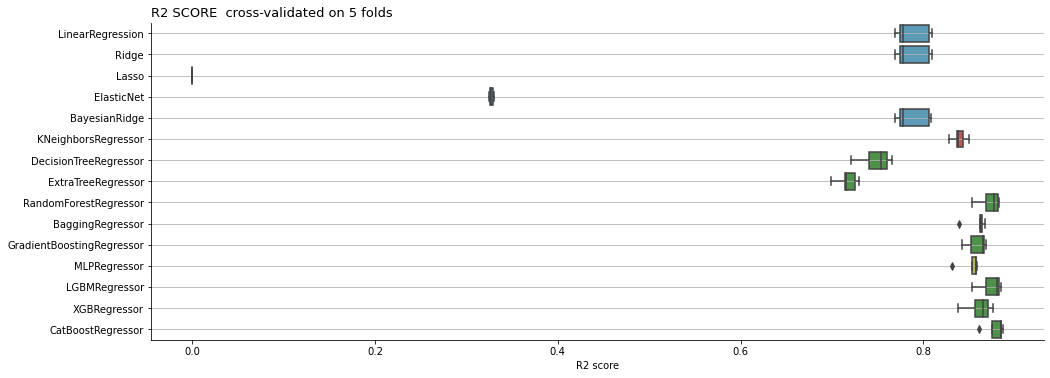

Mean of all linear-Models: 0.538
Mean of all tree-Models: 0.834
Mean of all neighbor-Models: 0.839
Mean of all neuronal-Models: 0.852


In [92]:
data = df_sps_int_log
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_sps_log_int_mean_r2 = lazy.mean_r2()

### 3.3 SPS log X

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [00:34<00:00,  2.30s/it]


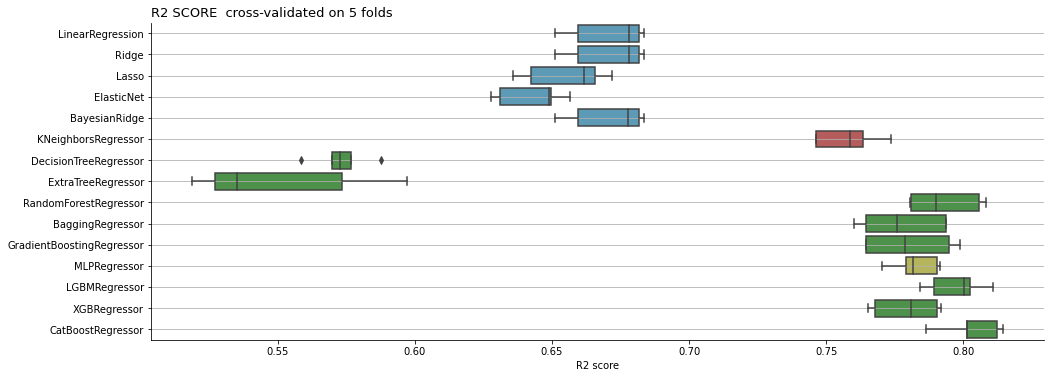

Mean of all linear-Models: 0.662
Mean of all tree-Models: 0.732
Mean of all neighbor-Models: 0.758
Mean of all neuronal-Models: 0.783


In [93]:
data = df_sps_log_X
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_sps_log_X_mean_r2 = lazy.mean_r2()

Color-Palette:
- linear = blue
- tree = green
- neighbor = red
- neuronal = yellow

## Summary

In [94]:
df_mpa_mean_r2["transformation"] = "mpa no trans"
df_mpa_log_y_mean_r2["transformation"] = "mpa y trans"
df_mpa_log_int_mean_r2["transformation"] = "mpa int trans"
df_mpa_log_X_mean_r2["transformation"] = "mpa X trans"
df_spg_mean_r2["transformation"] = "spg no trans"
df_spg_log_y_mean_r2["transformation"] = "spg y trans"
df_spg_log_int_mean_r2["transformation"] = "spg int trans"
df_spg_log_X_mean_r2["transformation"] = "spg X trans"
df_sps_mean_r2["transformation"] = "sps no trans"
df_sps_log_y_mean_r2["transformation"] = "sps y trans"
df_sps_log_int_mean_r2["transformation"] = "sps int trans"
df_sps_log_X_mean_r2["transformation"] = "sps X trans"

In [95]:
frames = [df_mpa_mean_r2,df_mpa_log_y_mean_r2,df_mpa_log_int_mean_r2,df_mpa_log_X_mean_r2,df_spg_mean_r2,df_spg_log_y_mean_r2,df_mpa_log_int_mean_r2,df_spg_log_X_mean_r2,df_sps_mean_r2,df_sps_log_y_mean_r2,df_mpa_log_int_mean_r2,df_sps_log_X_mean_r2]
result = pd.concat(frames)

In [96]:
result.to_csv(r'result.csv')

In [97]:
mpa_results = result[result['transformation'].str.contains("mpa")]
spg_results = result[result['transformation'].str.contains("spg")]
sps_results = result[result['transformation'].str.contains("sps")]

In [98]:
#report_sum_mean = report.groupby(['model']).mean()
#report_sum_mean=report_sum_mean.reindex(plot_order)
#report_sum_mean['model'] = report_sum_mean.index
#report_sum_mean.reset_index(drop=True, inplace=True)
#report_sum_mean=report_sum_mean[["model","score"]]
#report_sum_mean

In [106]:
messsystem_frames = [df_mpa_log_X_mean_r2,df_spg_log_X_mean_r2,df_sps_log_X_mean_r2]
messsystem_frames = [df_mpa_log_int_mean_r2,df_spg_log_int_mean_r2,df_sps_log_int_mean_r2]
messsystem_result = pd.concat(messsystem_frames)
messsystem_result = messsystem_result.drop([232])

In [111]:
messsystem_result['transformation'] = messsystem_result['transformation'].replace(['mpa X trans','spg X trans','sps X trans'],['mpa','spg','sps'])
messsystem_result['transformation'] = messsystem_result['transformation'].replace(['mpa int trans','spg int trans','sps int trans'],['mpa','spg','sps'])

In [108]:
messsystem_result = messsystem_result[messsystem_result.model != "Lasso"]
messsystem_result = messsystem_result[messsystem_result.model != "ElasticNet"]

In [109]:
messsystem_result.to_csv(r'messsystem_result.csv')

In [113]:
result

,Unnamed: 0,scorer,model,score,transformation
0,10,test_r2,LinearRegression,0.676729,mpa no trans
1,11,test_r2,LinearRegression,0.638296,mpa no trans
2,12,test_r2,LinearRegression,0.673336,mpa no trans
3,13,test_r2,LinearRegression,0.666503,mpa no trans
4,14,test_r2,LinearRegression,0.662744,mpa no trans
...,...,...,...,...,...
895,290,test_r2,CatBoostRegressor,0.812290,sps X trans
896,291,test_r2,CatBoostRegressor,0.786457,sps X trans
897,292,test_r2,CatBoostRegressor,0.814466,sps X trans
898,293,test_r2,CatBoostRegressor,0.801196,sps X trans


In [103]:
result = pd.read_csv('result.csv')
messsystem_result = pd.read_csv('messsystem_result.csv')

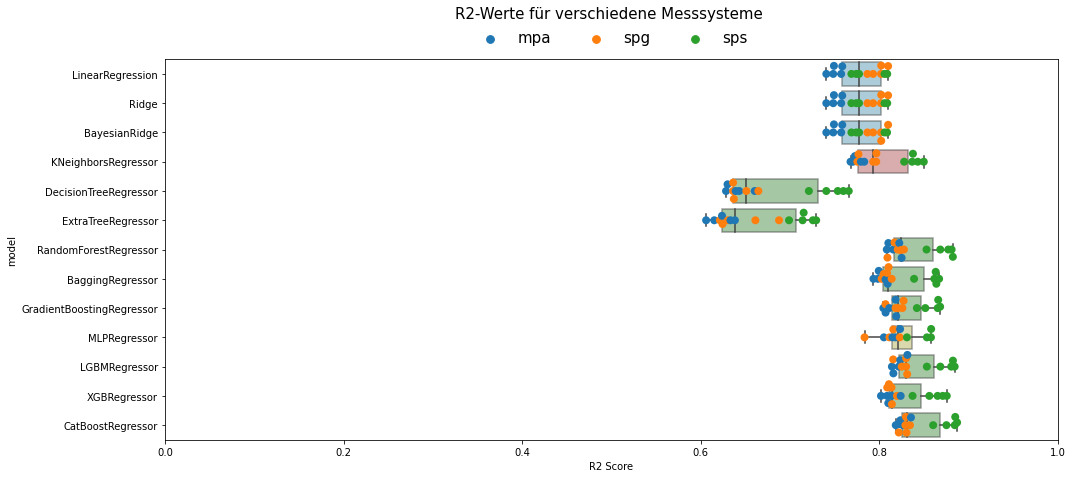

In [112]:
plot_data = messsystem_result
fig = plt.subplots(figsize=(16, 7))
colors = ["#4EA0C4","#4EA0C4","#4EA0C4","#C44E4E","#449D3E","#449D3E","#449D3E","#449D3E","#449D3E","#C4C44E","#449D3E","#449D3E","#449D3E"]
p =sns.boxplot(data=plot_data,x=plot_data["score"],y=plot_data["model"],palette=colors, boxprops=dict(alpha=.5))
P=sns.swarmplot(data=plot_data,x=plot_data["score"],y=plot_data["model"],hue=plot_data["transformation"],s=8)
p.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), ncol=3, title=None, frameon=False,fontsize=15)
plt.title("R2-Werte für verschiedene Messsysteme \n\n",fontsize=15)
plt.xlabel("R2 Score")
plt.xlim([0,1])
plt.show()

In [75]:
mpa_results = mpa_results.drop([232])

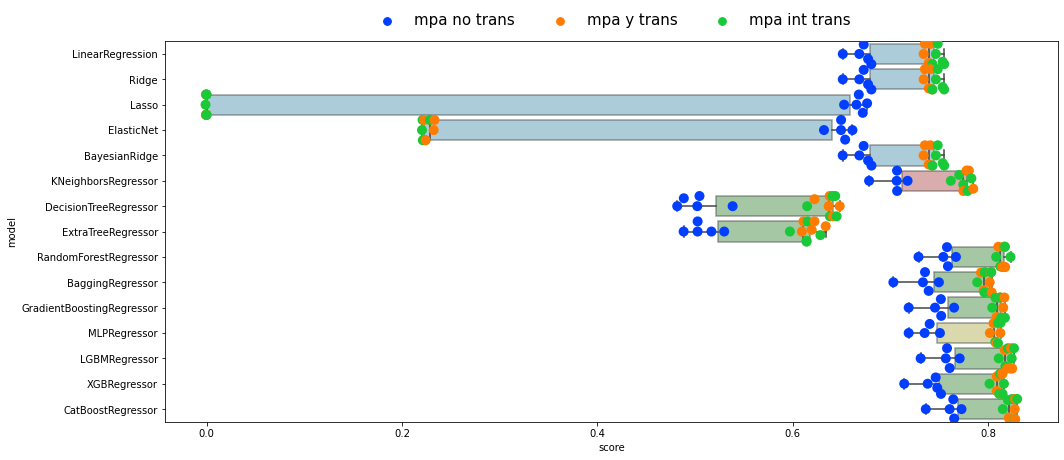

In [76]:
plot_data = mpa_results
fig = plt.subplots(figsize=(16, 7))
colors = ["#4EA0C4", "#4EA0C4", "#4EA0C4","#4EA0C4","#4EA0C4","#C44E4E","#449D3E","#449D3E","#449D3E","#449D3E","#449D3E","#C4C44E","#449D3E","#449D3E","#449D3E"]
p =sns.boxplot(data=plot_data,x=plot_data["score"],y=plot_data["model"],palette=colors, boxprops=dict(alpha=.5))
P=sns.swarmplot(data=plot_data,x=plot_data["score"],y=plot_data["model"],hue=plot_data["transformation"],s=10,palette = "bright")
p.legend(loc="lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,fontsize=15)
plt.show()

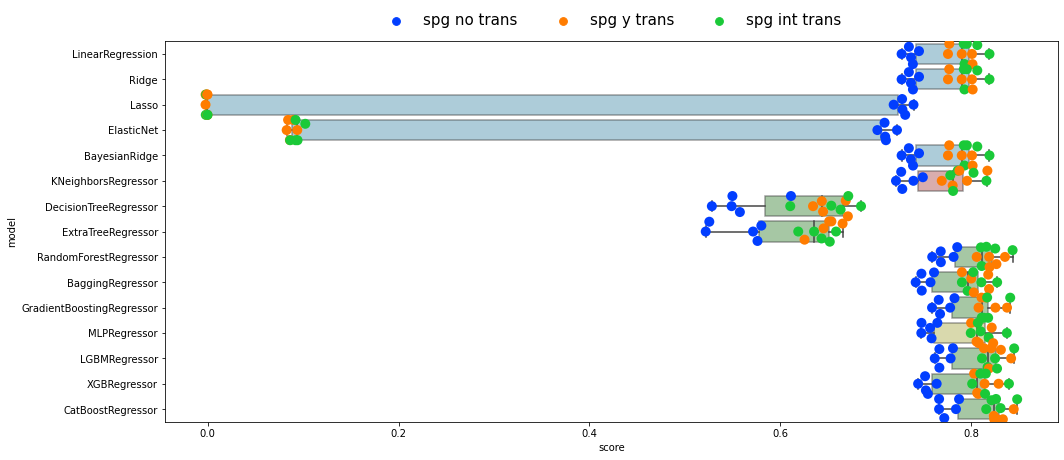

In [77]:
plot_data = spg_results
fig = plt.subplots(figsize=(16, 7))
colors = ["#4EA0C4", "#4EA0C4", "#4EA0C4","#4EA0C4","#4EA0C4","#C44E4E","#449D3E","#449D3E","#449D3E","#449D3E","#449D3E","#C4C44E","#449D3E","#449D3E","#449D3E"]
p =sns.boxplot(data=plot_data,x=plot_data["score"],y=plot_data["model"],palette=colors, boxprops=dict(alpha=.5))
P=sns.swarmplot(data=plot_data,x=plot_data["score"],y=plot_data["model"],hue=plot_data["transformation"],s=10,palette = "bright")
p.legend(loc="lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,fontsize=15)
plt.show()

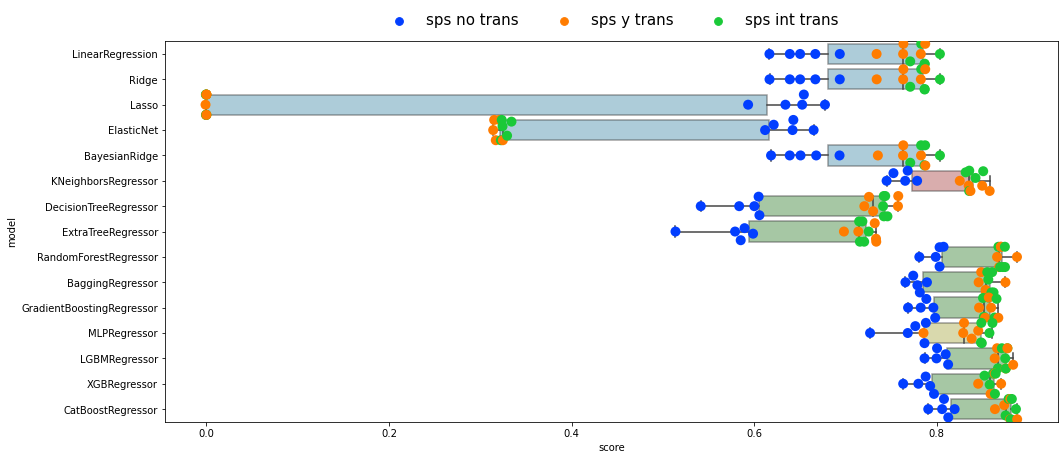

In [78]:
plot_data = sps_results
fig = plt.subplots(figsize=(16, 7))
colors = ["#4EA0C4", "#4EA0C4", "#4EA0C4","#4EA0C4","#4EA0C4","#C44E4E","#449D3E","#449D3E","#449D3E","#449D3E","#449D3E","#C4C44E","#449D3E","#449D3E","#449D3E"]
p =sns.boxplot(data=plot_data,x=plot_data["score"],y=plot_data["model"],palette=colors, boxprops=dict(alpha=.5))
P=sns.swarmplot(data=plot_data,x=plot_data["score"],y=plot_data["model"],hue=plot_data["transformation"],s=10,palette = "bright")
p.legend(loc="lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,fontsize=15)
plt.show()